In [11]:
import cvxpy as cp
import numpy as np
from Enhrenfest_methods import *
np.random.seed(22)

In [12]:
''' Now I want to create the following parameter for each type of agents

    - potential_reward_lst: reward rate
    - mu_lst: intensity under the active phase
    - lambda_lst: intensity under the passive phase

    - num_types: The number of types
    - scale: Adjust the numerical scale of intensity
'''

def sample_mu_values(num_types, scale = 10):
    # Sample mus
    mus = np.random.uniform(0, 1, num_types) * scale
    return list(mus)

def sample_lambda_values(num_types, scale = 10):
    # Sample mus
    lambdas = np.random.uniform(0, 1, num_types) * scale
    return list(lambdas)

In [13]:

## This generates the normal MDP process
def generate_transition_matrix_with_dummy_states(num_arms, num_states, num_dummy_states, mu_lst, lambda_lst, time_step):
    # Initialize transition matrices
    P = np.zeros((num_arms, num_states + num_dummy_states, 2, num_states + num_dummy_states))
    K = num_states - 1

    for n in range(num_arms):
        for s in range(num_states):
            if s == 0:
                # Boundary condition for state 0 (active)
                P[n, s, 1, s + num_states] = 1

                P[n, s, 0, s + 1] = lambda_lst[n] * (K - s) * time_step
                P[n, s, 0, s] = 1 - (lambda_lst[n] * (K - s) * time_step)
            if s == num_states - 1:
                # Boundary condition for state 9 (passive)
                P[n, s, 0, s] = 1

                P[n, s, 1, s - 1 + num_states] = mu_lst[n] * s * time_step
                P[n, s, 1, s + num_states] = 1 - mu_lst[n] * s * time_step

            else:
                P[n, s, 0, s + 1] = lambda_lst[n] * (K - s) * time_step
                P[n, s, 0, s] = 1 - lambda_lst[n] * (K - s) * time_step
                P[n, s, 1, s - 1 + num_states] = mu_lst[n] * s * time_step
                P[n, s, 1, s + num_states] = 1 - mu_lst[n] * s * time_step
        # Transitions within dummy states (s in S_a)
        for s_a in range(num_states, num_states + num_dummy_states):
            normal_state_index = s_a - num_states
            # Copy transitions from the corresponding normal state for action 0 within dummy states
            P[n, s_a, 0, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]
            P[n, s_a, 1, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]

    return P

In [14]:
def comparison(S, N, group_member_num, K, S_prime, A, T, mu_lst,lambda_lst,time_step,potential_reward_lst,num_simulations = 20000, type = 'General'):
       # change here to generate different types of transition matrices
    P = generate_transition_matrix_with_dummy_states(N, S, S, mu_lst, lambda_lst, time_step)
    P_original = P[:, :S, :, :S]+P[:,:S,:,S:]

    optimal_reward, fluid_reward, fluid_std = fluid_policy(N, T, S, S_prime, A, K, group_member_num, P, num_simulations, potential_reward_lst, time_step)
    random_reward, random_std = random_policy(N, T, S, S_prime, A, K, group_member_num, P, num_simulations, potential_reward_lst, time_step)
    Q_difference_reward, Q_difference_std =  Q_difference_policy(N, T, S, S_prime, A, K, group_member_num, P, num_simulations, potential_reward_lst, time_step)
    infinite_whittle_reward, infinite_whittle_std = infinite_whittle_policy(N, T, S, S_prime, A, K, group_member_num, P, num_simulations, potential_reward_lst, time_step)
    original_whittle_reward, original_whittle_std = original_whittle_policy(N, T, S, A, K, group_member_num, P_original, num_simulations, potential_reward_lst, time_step)


    experiment_synthetic_result = {
        "Optimal": (optimal_reward, None),
        "fluid": (fluid_reward, fluid_std),
        "inifinite whittle": (infinite_whittle_reward, infinite_whittle_std),
        "original whittle": (original_whittle_reward, original_whittle_std),
        "Q_difference": (Q_difference_reward, Q_difference_std),
        "random": (random_reward, random_std)
    }
    plot_methods_with_confidence(experiment_synthetic_result, N, T, K, group_member_num, num_simulations, type, lower_bound_method="random")

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Solver status: optimal
Optimal value: 7.217832258648182
Average total reward over 100 simulations: 20.73917404586426, stdev is 2.345346828374945
Number of pulls in dummy states (LP-based policy): 0
Average total achieved value over 100 simulations (Random policy): 10.486995112733087, stdev is 0.8871427314608632
Whittle Indices (including dummy states):
Average total achieved value over 100 simulations (General Finite Whittle index policy): 21.166156696887256, stdev is 1.83298185669486
Whittle Indices (including dummy states):
Average total achieved value over 100 simulations (General Infinite Whittle index policy): 21.00853149099537, stdev is 1.7865850775748164
Original Whittle Indices (including dummy states):
Average total achieved value over 100 simulations (General Infinite Whittle index policy): 10.818543145895456, stdev is 0.8404494230115029


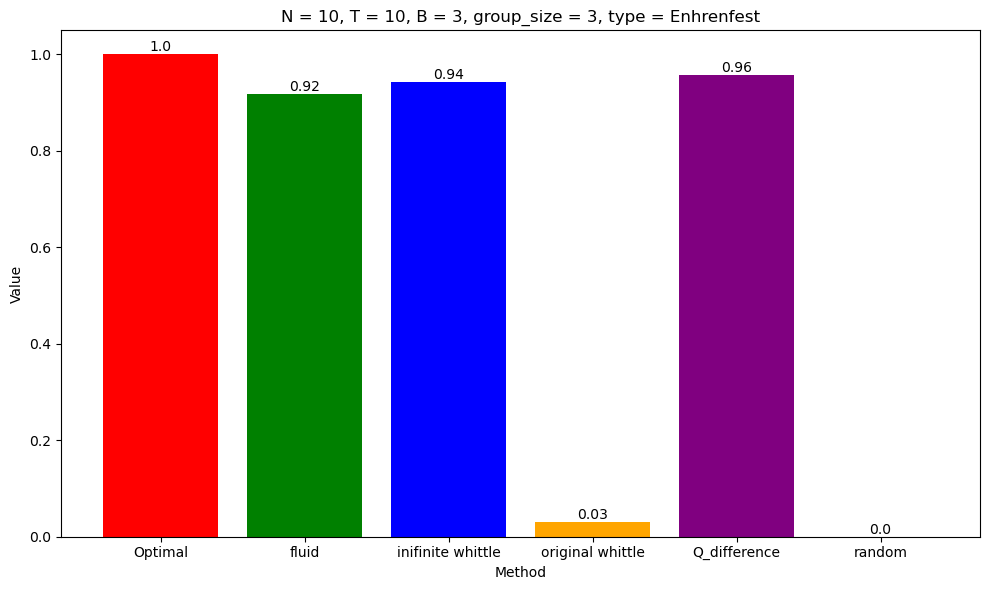

In [15]:
S = 10
N = 10
group_member_num = 3
K = 3
S_prime = S * 2
A = 2
T = 10
num_simulations = 100
time_step = 0.01
mu_lst = sample_mu_values(N)
lambda_lst = sample_lambda_values(N)
potential_reward_lst = np.random.uniform(1, 10, N)
comparison(S, N, group_member_num, K, S_prime, A, T, mu_lst,lambda_lst,time_step,potential_reward_lst,num_simulations, 'Enhrenfest')